# Simulating an *MA(2)* process and making forecasts

The purpose of this notebook is creating a Moving Averagre process of second order and analyzing it to make forecasts. First, let's view what a Moving Average process is.

## Defining a moving average process

> **Moving average process**: 
> In time series, an **$MA(q)$** model is a linear combination of the mean of series ($\mu$), the present error term ($\epsilon_t$), and past error terms ($\epsilon_{t-q}$). The magnitude of the impact of past errors on the present value is quantified using a coefficient denoted as $\theta_q$. Matehmatically, this is:
$$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$

> The order $q$ of the MA model determines the number of past error terms that affect the present value.
### Process to identify a MA model
The next diagram shows the steps to identify a MA model.


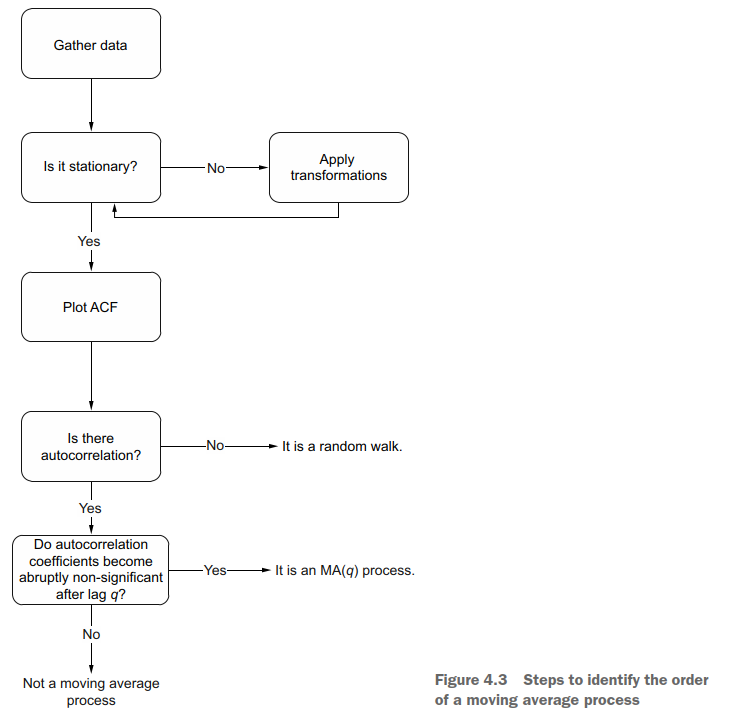

------------------------

## Actions to execute
In this notebook, we will simulate a MA(2) process from the equation:
$$y_t = 0.9 \theta_{t-1} + 0.3\theta_{t-2}$$
The actions to execute are:
1. Gather data: Simulate de MA(2) model with the above equation.
2. Test stationary.
    - Apply transformations until our series is stationary.
4. Plot ACF and get the order of our MA model: Get the acutocorrelation coefficients and the order of our MA model
5. Apply a method to forecast.

## Part 1. Gather data

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
# simulating process
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

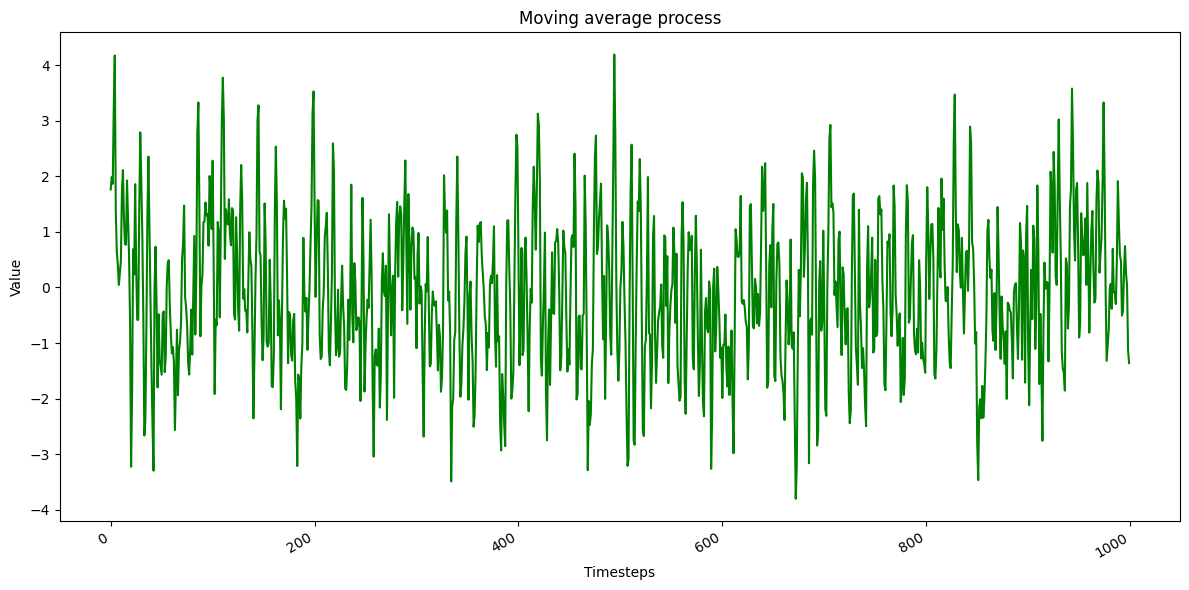

In [3]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(MA2_process, color='g')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Moving average process')
fig.autofmt_xdate()
plt.tight_layout()

## Par 2. Test stationary

To test stationary, Augmented Dickey-Fuller test will be used.

In [4]:
ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -9.880704273888863
p-value: 3.776826774708471e-17


Here, the p-value is much less than a significance of 0.05, hence our time series is stationary.

## Par 3. Plot ACF

Let's get the Autocorrelation Coefficients of our stationary-time series.

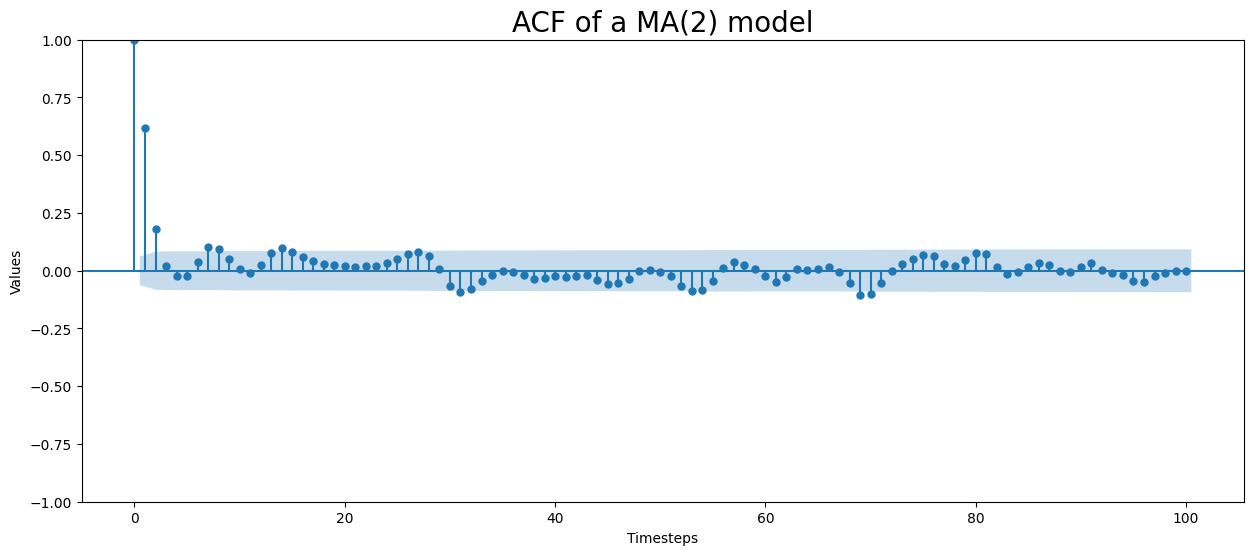

In [5]:
n_coef = 100

fig, ax = plt.subplots(figsize=(15,6))

# applying ACF
plot_acf(MA2_process, ax=ax, lags=n_coef)
ax.set(xlabel='Timesteps', ylabel='Values', title = 'ACF of a MA(2) model')
ax.title.set_size(20)
plt.show()

This ACF plot shows how the coefficients are significant up until lag 2. There are more significant coefficients but they are not too significant. Therephore, our time series is a MA process of second order.

## Part 4. Forecasting

Here, we will use ***rolling forecasting*** method with SARIMAX. The rolling method consists on training the model using SARIMAX and forecasting $q$ steps in the future, then, we train our model again with the new data and forecast the next two steps and so on, until all the test data has been forecasting to compare the final model.

In [6]:
# definig data as df
df_data = pd.DataFrame({'value': MA2_process})

# splitting data
train = df_data[:800]
test = df_data[800:]

In [7]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    """
    This function applys the rolling forecast method using SARIMAX in time series, ie,
    the model is train with the train data, then it is used to forecast the next n(window) steps. 
    After that, the model is trained again with the new data to forecast the next n(window) steps,
    and so on, until all the horizon steps have been forecasted.
    
    Parameters:
        df (pd.DataFrame): dataframe with the data.
        train_len (int): lenght of the train data.
        test_len (int): lenght of the test data.
        horizon (int): number of total steps to forecast.
        window (int): nuumber of steps to forecast in each iteration.
    
    Return:
        pred_MA (list): list with all the predictions.
    """
    total_len = train_len + horizon

    pred_MA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(0,0,2))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_MA.extend(oos_pred)
    
    return pd.DataFrame(pred_MA, columns=['pred_MA2']).reset_index(drop=True)

In [8]:
# Traingn and testing
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_MA2  = rolling_forecast(df_data, TRAIN_LEN, HORIZON, WINDOW)

test = pd.concat([test.reset_index(drop=True), pred_MA2], axis=1)
test.reset_index(drop=True, inplace=True)
test.index = test.index + 800

test.head()

,value,pred_MA2
800,0.536805,-0.861688
801,1.806869,-0.226673
802,1.073106,1.084657
803,-0.207198,0.219011
804,0.571581,-0.363464


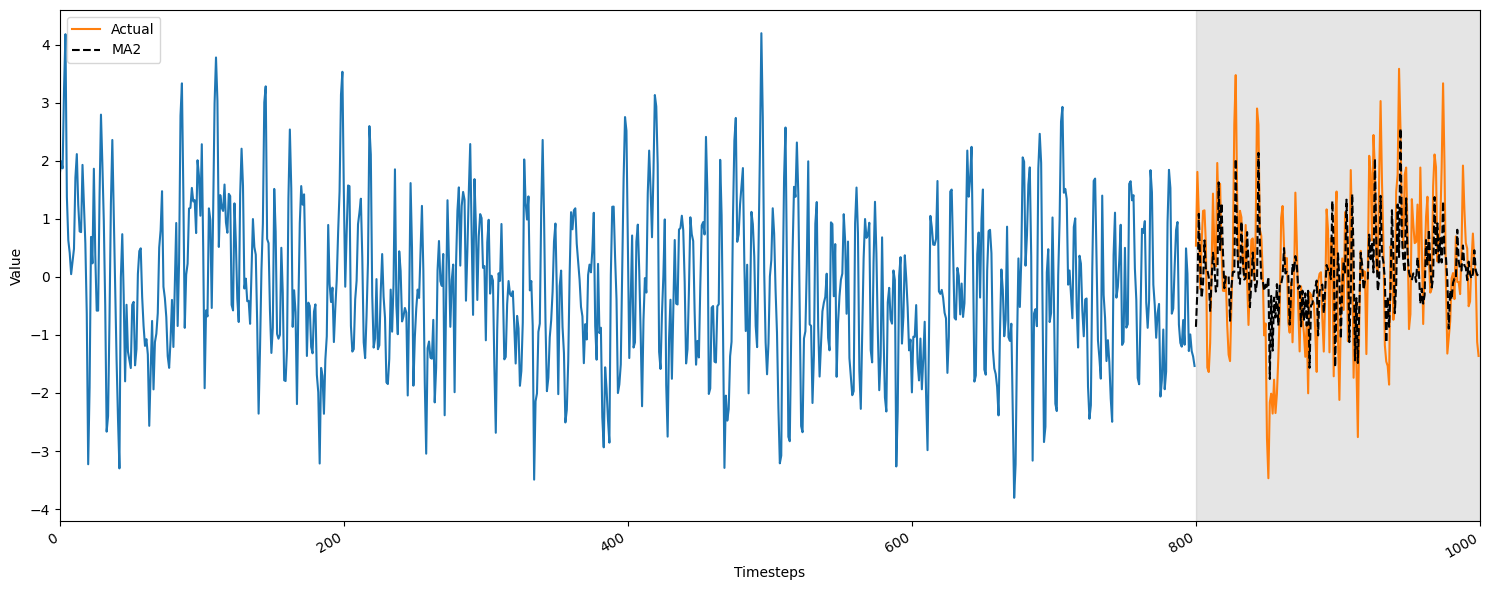

In [9]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_MA2'], 'k--', label='MA2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(0, 1000)
fig.autofmt_xdate()
plt.tight_layout()

### Testing our forecasting

In [11]:
# test using MSE
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])
mse_MA

1.1634184944768737

The MSE is too low, so that our model was a good perfomance.